# BM4D Experiment

In [1]:
import os

import bm4d
import numpy as np
import matplotlib.pyplot as plt

from module.utils import display_4d_image, compute_psnr_ssim_from_4d_ndarray, plot_2d_data, save_denoised_dicom

import h5py
import pydicom

from tqdm.notebook import tqdm

from skimage.metrics import peak_signal_noise_ratio as cal_psnr
from skimage.metrics import structural_similarity as cal_ssim

## Load dataset

In [2]:
with h5py.File('./dataset/preprocessed/PT_20p 150_120 OSEM_gauss_0.009.h5', 'r') as f:
    noisy_data = f['dataset'][...]
    restore_info = f['restore_info'][...]
    
print(f"Noisy data...{noisy_data.dtype} (shape:{noisy_data.shape}; range:[{np.min(noisy_data)},{np.max(noisy_data)}]; mean:{np.mean(noisy_data)}); std:{np.std(noisy_data)}")

print(restore_info)

# 
noise_level = 0.009

Noisy data...float64 (shape:(24, 71, 192, 192); range:[-0.018414393986850297,1.0298518324719883]; mean:0.5030665574527993); std:0.02335746313650884
b'{"mean": 201.12048776036573, "std": 1412.4139804758772, "min": -23.34168377224119, "max": 23.05689405684542}'


## Example denoising 

In [ ]:
# demonstrate 
time_idx = 11
depth_idx = 38


#
noisy_image = noisy_data[time_idx]
print(f"noisy_image: dtype:{noisy_image.dtype} range({np.min(noisy_image)},{np.max(noisy_image)}) mean:{np.mean(noisy_image)} std:{np.std(noisy_image)}")


# process denoising
denoised_image = bm4d.bm4d(noisy_image, noise_level)
print(f"denoised_image: dtype:{denoised_image.dtype} range({np.min(denoised_image)},{np.max(denoised_image)}) mean:{np.mean(denoised_image)} std:{np.std(denoised_image)}")


# calculate PSNR and SSIM
data_range_noisy = np.max(noisy_image) - np.min(noisy_image)
data_range_denoised = np.max(denoised_image) - np.min(denoised_image)
data_range = max(data_range_noisy, data_range_denoised)

print(f"PSNR: {cal_psnr(denoised_image, noisy_image, data_range=data_range)} SSIM: {cal_psnr(denoised_image, noisy_image, data_range=data_range)} MAE: {np.mean(np.abs(noisy_image - denoised_image))}")


# show result
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
ax = axes.ravel()

ax[0].set_axis_off()
ax[0].imshow(noisy_image[depth_idx], cmap='hot')
ax[0].set_title("origin")

ax[1].set_axis_off()
ax[1].imshow(denoised_image[depth_idx], cmap='hot')
ax[1].set_title("denoised")

ax[2].set_axis_off()
ax[2].imshow(noisy_image[depth_idx] - denoised_image[depth_idx], cmap='hot')
ax[2].set_title("diff")

noisy_image: dtype:float64 range(0.40095936420489114,1.01743689314847) mean:0.5026486778473855 std:0.02246752868371976


## Process denoising

In [8]:
%%time 
# denoised 

denoised_data = np.zeros_like(noisy_data)

with tqdm(total=noisy_data.shape[0]) as pbar:
    for time_idx in range(noisy_data.shape[0]):
        sub_image = noisy_data[time_idx, :, :, :]
        denoised_sub_image = bm4d.bm4d(sub_image, noise_level)
        denoised_data[time_idx, :, :, :] = denoised_sub_image
        pbar.update(1)
    
            
print(f"denoised_data: dtype:{denoised_data.dtype} range({np.min(denoised_data)},{np.max(denoised_data)}) mean:{np.mean(denoised_data)} std:{np.std(denoised_data)}")

CPU times: total: 0 ns
Wall time: 0 ns


  0%|          | 0/24 [00:00<?, ?it/s]

denoised_data: dtype:float64 range(-0.01772739551961422,1.0237685441970825) mean:0.5030646902655161 std:0.02146560849134394


## Evaluation

Calculate PSNR, SSIM

PSNR(avg): 41.6651410281938; SSIM(avg): 0.9317916596319542
argmax: (3, 10)
argmin: (4, 1)


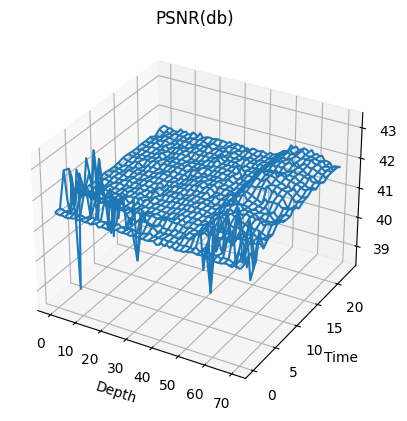

argmax: (3, 12)
argmin: (4, 1)


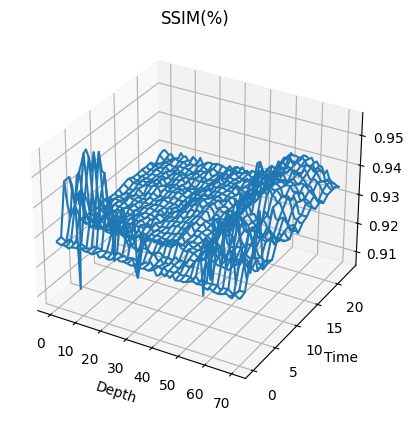

In [9]:
# calcualte PSNR, SSIM between denoised data and noisy data
data_range_noisy = np.max(noisy_data) - np.min(noisy_data)
data_range_denoised = np.max(denoised_data) - np.min(denoised_data)
data_range = max(data_range_noisy, data_range_denoised)

#
all_psnr, all_ssim = compute_psnr_ssim_from_4d_ndarray(denoised_data, noisy_data, data_range)

#
print(f"PSNR(avg): {np.mean(all_psnr)}; SSIM(avg): {np.mean(all_ssim)}")

plot_2d_data(all_psnr, "PSNR(db)")
plot_2d_data(all_ssim, "SSIM(%)")

## Save denormalized denoised image into int16 DICOM file

In [10]:
# denormalzied denoised data
mean_val = 201.12048776036573
std_val = 1412.4139804758772
max_val = 23.05689405684542
min_val = -23.34168377224119


denormalized_denoised_data = denoised_data * (max_val - min_val) + min_val
denormalized_denoised_data = denormalized_denoised_data * std_val + mean_val

denormalized_denoised_data = np.clip(denormalized_denoised_data, np.iinfo(np.int16).min, np.iinfo(np.int16).max).astype(np.int16)


print(f"denormalized_denoised_data: dtype:{denormalized_denoised_data.dtype} range({np.min(denormalized_denoised_data)},{np.max(denormalized_denoised_data)}) mean:{np.mean(denormalized_denoised_data)} std:{np.std(denormalized_denoised_data)}")

display_4d_image(denormalized_denoised_data)

denormalized_denoised_data: dtype:int16 range(-32768,32767) mean:200.72937034005975 std:1406.555266205699


interactive(children=(IntSlider(value=0, description='Time', max=23), IntSlider(value=0, description='Slice', …

In [11]:
origin_dicom_folder = './dataset/TracPETperf-D2-PhantomExperiments2/PT_20p 150_120 OSEM'

output_folder = './dataset/denoised/BM4D/PT_20p 150_120 OSEM_gauss_0.009'

save_denoised_dicom(origin_dicom_folder, denormalized_denoised_data, output_folder)

Processing time points:   0%|          | 0/24 [00:00<?, ?it/s]

Saved 1704 denoised DICOM files.
